In [1]:
# %%
# 单元格 1: 配置环境
# 运行此单元格将安装 (或更新) 我们需要的库
# scikit-image 是我们的主角
# pandas 用于整理测量结果
print("Installing pandas, matplotlib, numpy, scipy, scikit-image...")
!pip install --upgrade pandas matplotlib numpy scipy scikit-image openpyxl
print("Installation complete!")

Installing pandas, matplotlib, numpy, scipy, scikit-image...
  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ---------------------------------------- 12.8/12.8 MB 20.6 MB/s  0:00:00
Using cached imageio-2.37.0-py3-none-any.whl (315 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)

Installation complete!


In [2]:
# %%
# 单元格 2: 导入必要的库
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# 导入 scikit-image 的核心模块
import skimage.io as io               # 用于读写图像
import skimage.filters as filters     # 滤波模块
import skimage.measure as measure     # 测量模块
import skimage.morphology as morphology # 形态学模块 (用于清理)
import skimage.draw as draw           # 绘图模块 (用于生成假数据)

# 设置 matplotlib 在 notebook 中内联显示
%matplotlib inline
plt.style.use('seaborn-v0_8-ticks')

print("Core libraries imported successfully. Ready to start.")

Core libraries imported successfully. Ready to start.


Generating simulated TEM image...
Successfully generated and saved 'synthetic_tem_image.png'.


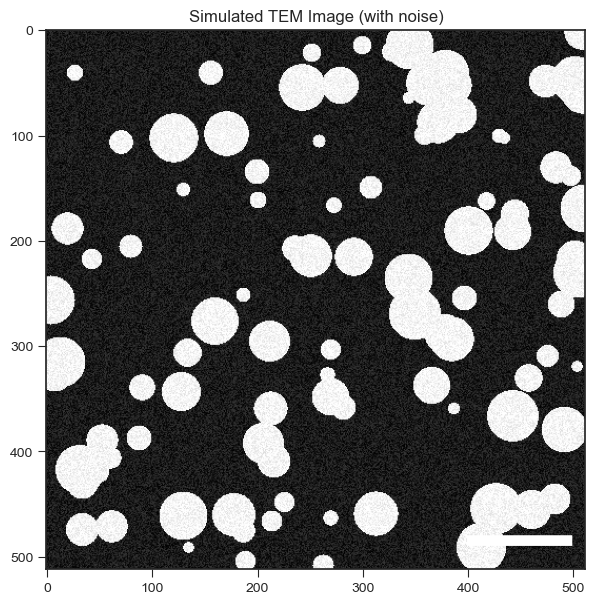

In [3]:
# %%
# 单元格 3: 模拟生成一张TEM图像
# (为了让所有人都能运行，我们不依赖本地图片，而是“画”一张)
# 我们将模拟一张512x512的图，上面有100个大小不一的颗粒

print("Generating simulated TEM image...")
IMAGE_SIZE = 512
NUM_PARTICLES = 100
IMAGE_FILE = "synthetic_tem_image.png"

# 1. 创建一个黑色背景
image = np.zeros((IMAGE_SIZE, IMAGE_SIZE), dtype=np.uint8)

# 2. 随机生成颗粒的位置和半径
np.random.seed(42) # 保证每次随机结果一致
centers = np.random.randint(0, IMAGE_SIZE, size=(NUM_PARTICLES, 2))
radii = np.random.uniform(5, 25, size=NUM_PARTICLES) # 半径在5到25像素

# 3. 在背景上“画”出白色的圆形颗粒
for center, radius in zip(centers, radii):
    # 使用 skimage.draw 画一个实心圆
    rr, cc = draw.disk(center, radius, shape=image.shape)
    image[rr, cc] = 200 # 颗粒亮度为 200 (灰色)

# 4. 模拟背景（灰色背景 + 噪声）
# (np.random.rand(...) - 0.5) * 50 会产生 -25 到 25 的噪声
image_noisy = image.astype(float) + 50.0 + (np.random.rand(IMAGE_SIZE, IMAGE_SIZE) - 0.5) * 50
image_noisy = np.clip(image_noisy, 0, 255).astype(np.uint8) # 确保亮度在 0-255 范围

# 5. (可选) 模拟一个模糊的 "Scale Bar" (刻度尺)
image_noisy[480:490, 400:500] = 255

# 6. 保存这张模拟图像
io.imsave(IMAGE_FILE, image_noisy)

print(f"Successfully generated and saved '{IMAGE_FILE}'.")

# 7. 绘制我们模拟的图像看看
plt.figure(figsize=(7, 7))
plt.imshow(image_noisy, cmap='gray')
plt.title('Simulated TEM Image (with noise)')
plt.show()

--- Starting Image Processing Pipeline for 'synthetic_tem_image.png' ---
Image filtering, segmentation, and cleaning complete.


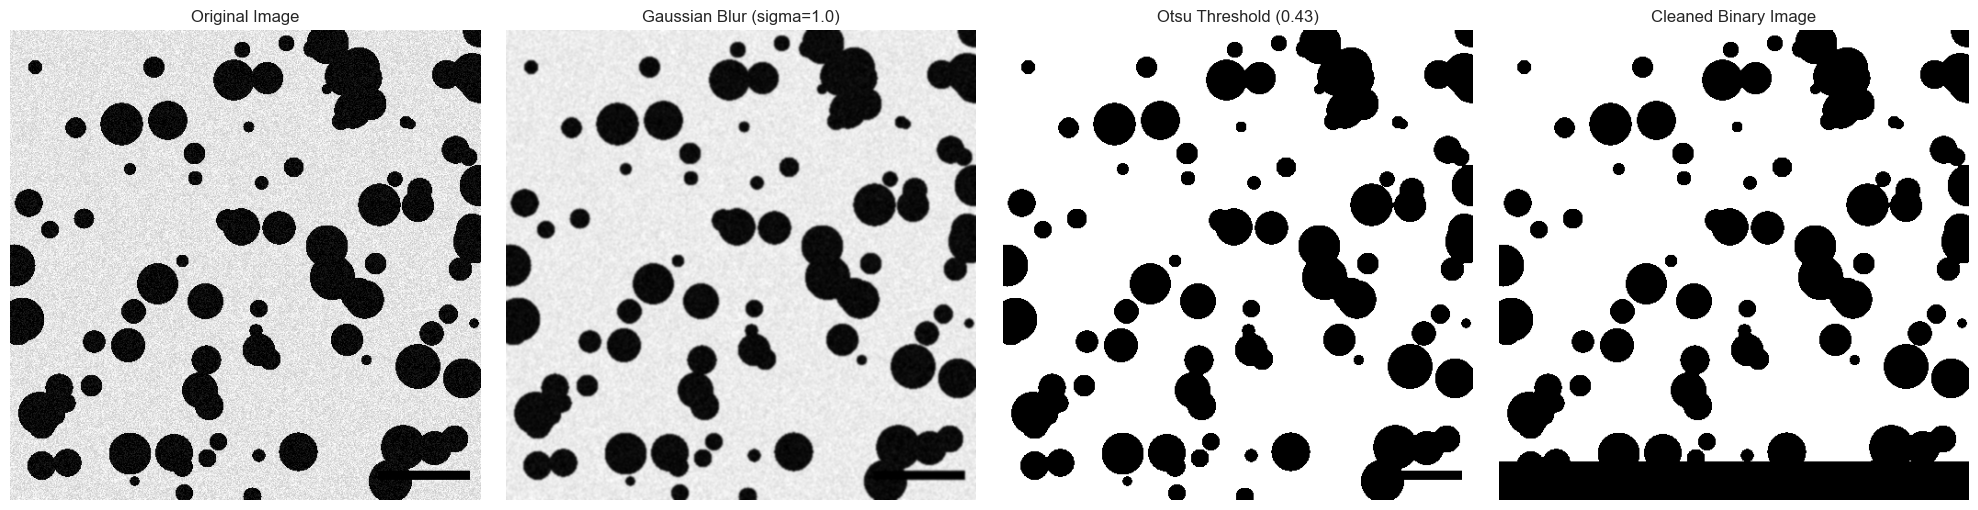

In [4]:
# %%
# 单元格 4: 图像处理流水线 (滤波 与 分割)

print(f"--- Starting Image Processing Pipeline for '{IMAGE_FILE}' ---")

# 1. (IO) 读取图像
# as_gray=True 确保以灰度图形式读取
img = io.imread(IMAGE_FILE, as_gray=True)
# 图像在skimage中被读取为 0.0 到 1.0 之间的浮点数
# 我们可以转为 0-255 整数，更直观
img = (img * 255).astype(np.uint8)

# 2. (Filtering) 滤波
# 使用“高斯滤波”去除噪声，sigma值越大，图像越模糊
img_blur = filters.gaussian(img, sigma=1.0)

# 3. (Segmentation) 阈值分割
# 使用 Otsu's 方法自动找到最佳阈值
# 这种方法假设图像亮度只有两类（背景和颗粒），它会自动找到最佳分界线
thresh_otsu = filters.threshold_otsu(img_blur)

# 4. (Binarization) 二值化
# 所有亮度 > 阈值的像素 = 颗粒 (True)
# 所有亮度 <= 阈值的像素 = 背景 (False)
binary_image = img_blur > thresh_otsu

# 5. (Morphology) 清理图像
# 移除小的噪声点（比如面积小于100个像素的白点）
binary_cleaned = morphology.remove_small_objects(binary_image, min_size=100)
# 移除刻度尺 (假设它在底部)
binary_cleaned[470:, :] = False 

print("Image filtering, segmentation, and cleaning complete.")

# 6. 可视化处理的中间步骤
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(img_blur, cmap='gray')
axes[1].set_title('Gaussian Blur (sigma=1.0)')
axes[2].imshow(binary_image, cmap='gray')
axes[2].set_title(f'Otsu Threshold ({thresh_otsu:.2f})')
axes[3].imshow(binary_cleaned, cmap='gray')
axes[3].set_title('Cleaned Binary Image')
for ax in axes:
    ax.set_axis_off()
plt.tight_layout()
plt.show()

In [5]:
# %%
# 单元格 5: 颗粒标记 与 测量
# 这是最关键的一步

print("--- Labeling and Measuring Particles ---")

# 1. (Labeling) 标记颗粒
# skimage.measure.label 会扫描二值图像，
# 并给每一个独立的白色区域一个唯一的整数ID (1, 2, 3...)
# 0 代表背景
labels = measure.label(binary_cleaned)

# 2. (Measurement) 测量属性
# regionprops_table 是最强大的函数
# 它会测量 'labels' 中每个ID（每个颗粒）的属性
# 我们指定需要测量 'area' (面积) 和 'equivalent_diameter_area' (等效直径)
properties = [
    'label', 
    'area', 
    'equivalent_diameter_area' # 面积等效圆的直径
]

props_table = measure.regionprops_table(labels, properties=properties)

# 3. (Pandas) 转换为 DataFrame
df_particles = pd.DataFrame(props_table)

# 4. 换算为真实尺度
# 假设我们从电镜标尺得知：1 像素 = 0.2 nm (这个值你需要自己标定)
PIXEL_TO_NM_SCALE = 0.2 
df_particles['diameter (nm)'] = df_particles['equivalent_diameter_area'] * PIXEL_TO_NM_SCALE
df_particles['area (nm^2)'] = df_particles['area'] * (PIXEL_TO_NM_SCALE ** 2)

print(f"Measurement complete. Found {len(df_particles)} particles.")
print("\n--- Particle Measurement Results (First 10) ---")
print(df_particles.head(10))

--- Labeling and Measuring Particles ---
Measurement complete. Found 2 particles.

--- Particle Measurement Results (First 10) ---
   label      area  equivalent_diameter_area  diameter (nm)  area (nm^2)
0      1  179840.0                478.517920      95.703584      7193.60
1      2       2.0                  1.595769       0.319154         0.08



--- Visualizing Results ---


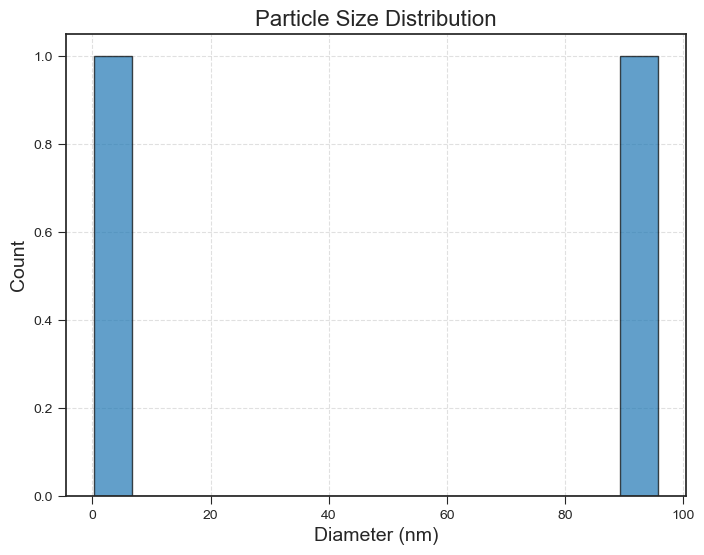


--- Particle Diameter Statistics (nm) ---
count     2.000000
mean     48.011369
std      67.446977
min       0.319154
25%      24.165261
50%      48.011369
75%      71.857476
max      95.703584
Name: diameter (nm), dtype: float64


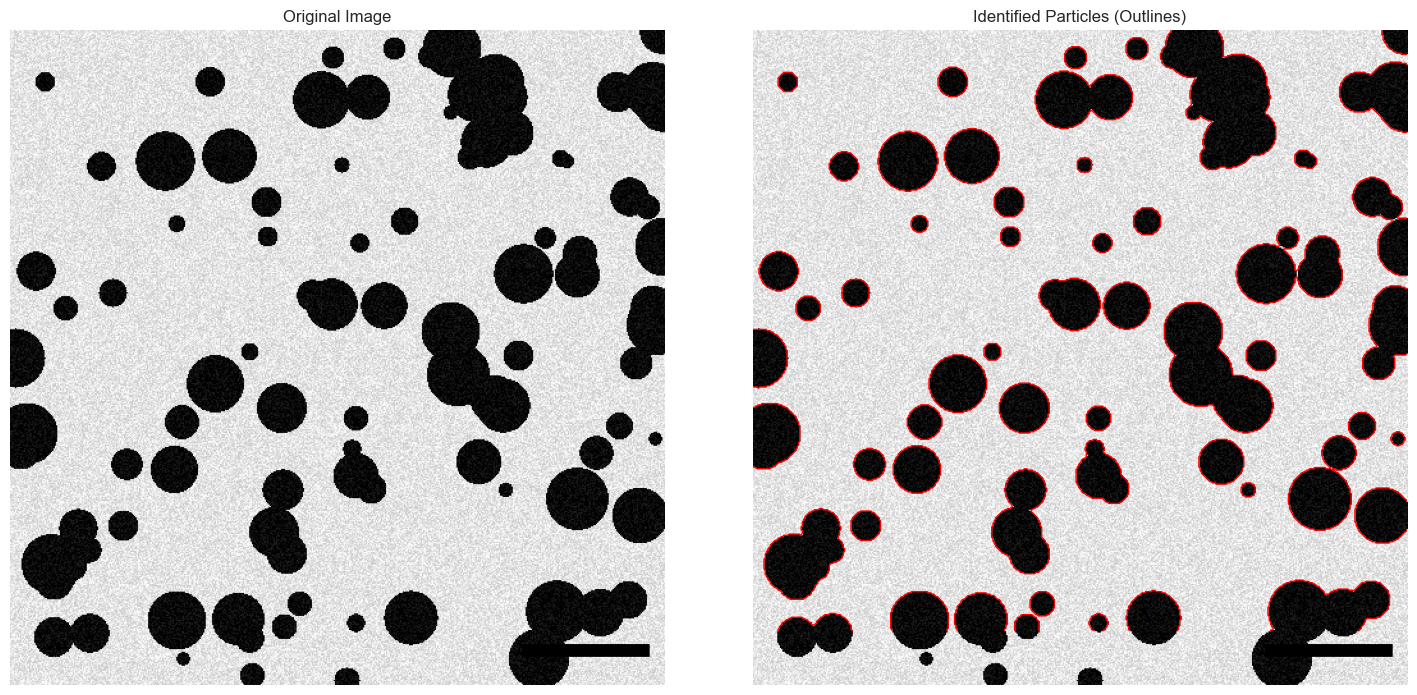


--- Analysis Finished ---


In [8]:
# %%
# 单元格 6: 结果可视化 (直方图 + 覆盖图)

print("\n--- Visualizing Results ---")

# 1. 绘制粒径分布直方图
plt.figure(figsize=(8, 6))
# 使用 'diameter (nm)' 这一列数据
plt.hist(df_particles['diameter (nm)'], bins=15, edgecolor='black', alpha=0.7)
plt.title('Particle Size Distribution', fontsize=16)
plt.xlabel('Diameter (nm)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 2. 打印统计数据
stats = df_particles['diameter (nm)'].describe()
print("\n--- Particle Diameter Statistics (nm) ---")
print(stats)

# 3. (高级) 绘制原图 + 识别出的颗粒轮廓
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# 左图：原图
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].set_axis_off()

# 右图：原图 + 识别出的颗粒轮廓
axes[1].imshow(img, cmap='gray')
axes[1].set_title('Identified Particles (Outlines)')
axes[1].set_axis_off()

# 遍历每一个识别出的颗粒
for region in measure.regionprops(labels):
    # region.bbox 给出颗粒的包围盒 (min_row, min_col, max_row, max_col)
    min_row, min_col, max_row, max_col = region.bbox
    # region.coords 给出所有像素点的坐标
    
    # 绘制颗粒的凸包 (convex_hull) 轮廓
    # 这是一个更平滑、更接近颗粒形状的轮廓
    # axes[1].plot(region.coords[:, 1], region.coords[:, 0], '.b', markersize=1) # 绘制所有像素点
    
    # --- 修复: 检查 region.image 是否太小 ---
    # find_contours 要求数组至少为 2x2
    if region.image.shape[0] < 2 or region.image.shape[1] < 2:
        continue # 跳过这个 1D 的"颗粒" (通常是噪声)
    # --- 修复结束 ---

    # 获取轮廓线（edges）
    # find_contours 返回的是多个轮廓的列表，每个轮廓是(y, x)坐标数组
    contours = measure.find_contours(region.image, 0.5) # 0.5是二值化的阈值
    
    for n, contour in enumerate(contours):
        # 将轮廓坐标转换回原始图像坐标系
        # region.image 相对其包围盒的左上角 (min_row, min_col)
        axes[1].plot(contour[:, 1] + min_col, contour[:, 0] + min_row, color='red', linewidth=1)

plt.tight_layout()
plt.show()

print("\n--- Analysis Finished ---")